# Libary import

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import os
import json

# from google.colab import drive # delete this line if not used on colab
# drive.mount("/content/drive", force_remount = True) # delete this line if not used on colab

Mounted at /content/drive


In [ ]:
result_path = "/content/drive/MyDrive/TFE/Results/ExperimentFirstPart"
tex_path = "/content/drive/MyDrive/TFE/Texfile"
image_path = "/content/drive/MyDrive/TFE/Images/ExperimentFirstPart"
metrics = ["accuracy", "precision", "recall", "f1", "pr_auc", "roc_auc"]

# Loading and plotting the different experiment

In [ ]:
def load_results(result_path, filename_keyword, metrics_list=["pr_auc", "roc_auc"]):
    """
    Loads and aggregates results from multiple JSON files containing model evaluation metrics.

    The function searches for files in the specified directory whose filenames contain the given keyword,
    extracts fine-tuning, early stopping, and class imbalance settings from the files, and organizes
    the corresponding metrics into a dictionary.

    Args:
        result_path (str): Path to the directory containing result JSON files.
        filename_keyword (str): Keyword used to filter which files to load.
        metrics_list (list of str, optional): List of metric names to extract from each file.
                                              Defaults to ["pr_auc", "roc_auc"].

    Returns:
        dict: Dictionary where keys are configuration identifiers (e.g., "FT_ES_W_pr_auc")
              and values are dictionaries containing 'mean' and 'std' for each metric.
    """
    save_dict = {}

    for file in os.listdir(result_path):
        if filename_keyword in file:
            with open(os.path.join(result_path, file), 'r') as f:
                data = json.load(f)

            # Determine condition labels
            fine_tuning = "N" if "Fine tuning" not in data else "FT" if data["Fine tuning"] else "FE"
            early_stopping = "ES" if data.get("early_stopping", False) else "NES"
            class_imbalanced = "O" if data.get("oversampling", False) else "W" if data.get("weighting", False) else "N"

            name = f"{fine_tuning}_{early_stopping}_{class_imbalanced}"

            # Extract specified metrics
            for m in metrics_list:
                if f"{name}_{m}" not in save_dict:
                    save_dict[f"{name}_{m}"] = {}

                if "metrics_summary" in data:
                    save_dict[f"{name}_{m}"]["mean"] = data["metrics_summary"].get(f"{m}_mean", 0)
                    save_dict[f"{name}_{m}"]["std"] = data["metrics_summary"].get(f"{m}_std", 0)
                else:
                    save_dict[f"{name}_{m}"]["mean"] = data["metrics"].get(f"{m}_mean", 0)
                    save_dict[f"{name}_{m}"]["std"] = data["metrics"].get(f"{m}_std", 0)

    return save_dict


def plot_grouped_bars(save_dict, group_type, title, image_path, metrics_list=["pr_auc", "roc_auc"]):
    """
    Plots grouped bar charts to visualize model performance under different experimental conditions.

    The function groups results based on a selected condition type (e.g., 'Fine Tuning', 'Early Stopping',
    or 'Class Imbalance') and plots bars for specified metrics.

    Args:
        save_dict (dict): Dictionary containing results from multiple experiments (output of load_results).
        group_type (str): Type of condition to vary ('Fine Tuning', 'Early Stopping', 'Class Imbalance').
        title (str): Title of the plot.
        image_path (str): File path to save the plot image.
        metrics_list (list of str, optional): List of metrics to include in the plot.
                                              Defaults to ["pr_auc", "roc_auc"].

    Returns:
        None: The plot is displayed and saved to the specified image_path.
    """
    types = {
        "Class Imbalance": ["N", "O", "W"],
        "Early Stopping": ["ES", "NES"],
        "Fine Tuning": ["FT", "FE"]
    }

    label_mapping = {
        "N": "None",
        "O": "Oversampling",
        "W": "Weighting",
        "ES": "Early Stopping",
        "NES": "No Early Stopping",
        "FT": "Fine Tuning",
        "FE": "Feature Extraction"
    }

    grouped = {}

    for key, values in save_dict.items():
        parts = key.split("_")
        fine_tuning = parts[0]
        early_stopping = parts[1]
        class_imbalance = parts[2]
        metric = "_".join(parts[3:])

        if group_type == "Fine Tuning":
            varying_value = fine_tuning
            group = f"{early_stopping}_{class_imbalance}"
        elif group_type == "Early Stopping":
            varying_value = early_stopping
            group = f"{fine_tuning}_{class_imbalance}"
        elif group_type == "Class Imbalance":
            varying_value = class_imbalance
            group = f"{fine_tuning}_{early_stopping}"

        if group not in grouped:
            grouped[group] = {}

        if varying_value not in grouped[group]:
            grouped[group][varying_value] = {}

        grouped[group][varying_value][metric] = {
            "mean": values["mean"],
            "std": values["std"]
        }

    group_metric_pairs = []
    for metric in metrics_list:
        for g in grouped.keys():
            group_metric_pairs.append((g, metric))

    x = np.arange(len(group_metric_pairs))
    bar_width = 0.2

    fig, ax = plt.subplots(figsize=(10, 6))

    for i, ci in enumerate(types[group_type]):
        offset = i * bar_width
        y = [grouped.get(g, {}).get(ci, {}).get(m, {}).get("mean", 0) for (g, m) in group_metric_pairs]
        yerr = [grouped.get(g, {}).get(ci, {}).get(m, {}).get("std", 0) for (g, m) in group_metric_pairs]
        ax.bar(x + offset, y, yerr=yerr, width=bar_width, label=label_mapping.get(ci, ci), capsize=5)

    labels = [f"{g} - {m}" for (g, m) in group_metric_pairs]
    total_width = len(types[group_type]) * bar_width
    ax.set_xticks(x + total_width / 2 - bar_width / 2)
    ax.set_xticklabels(labels, rotation=45)
    ax.set_ylabel("Value")
    ax.set_title(title)
    ax.legend()
    plt.tight_layout()
    plt.savefig(image_path)
    plt.show()
    plt.close()

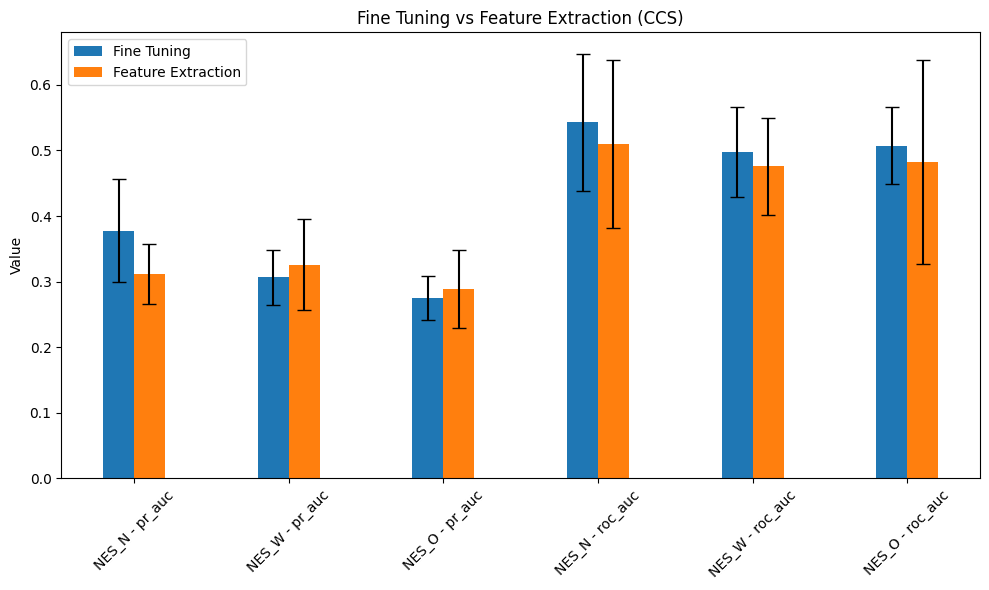

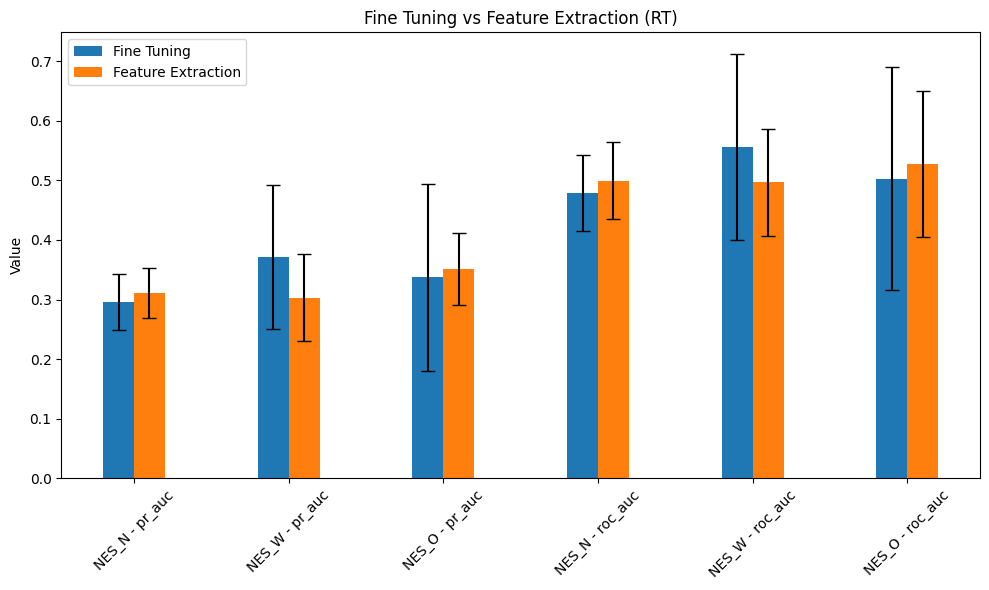

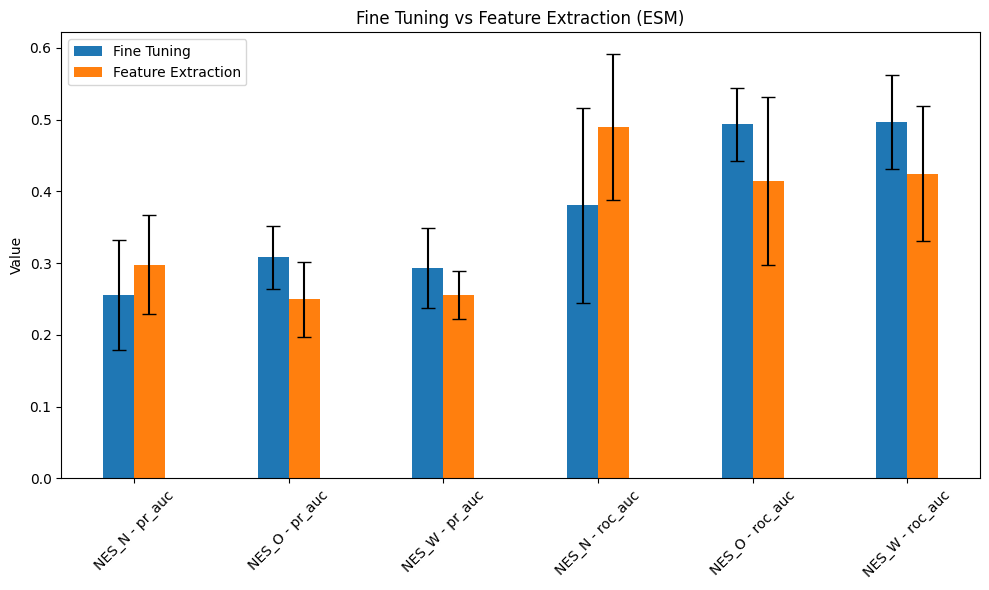

In [75]:
names = ["ValidProtocol_CCS", "ValidProtocol_RT", "ValidProtocol_ESM"]

for n in names:
    save_dict = load_results(result_path, n)

    if "Valid" in n:
        model_name = n.split("_")[1]
    else:
        model_name = n

    plot_grouped_bars(save_dict, "Fine Tuning", f"Fine Tuning vs Feature Extraction ({model_name})", f"{image_path}/FineTuningExperiment({model_name}).png")

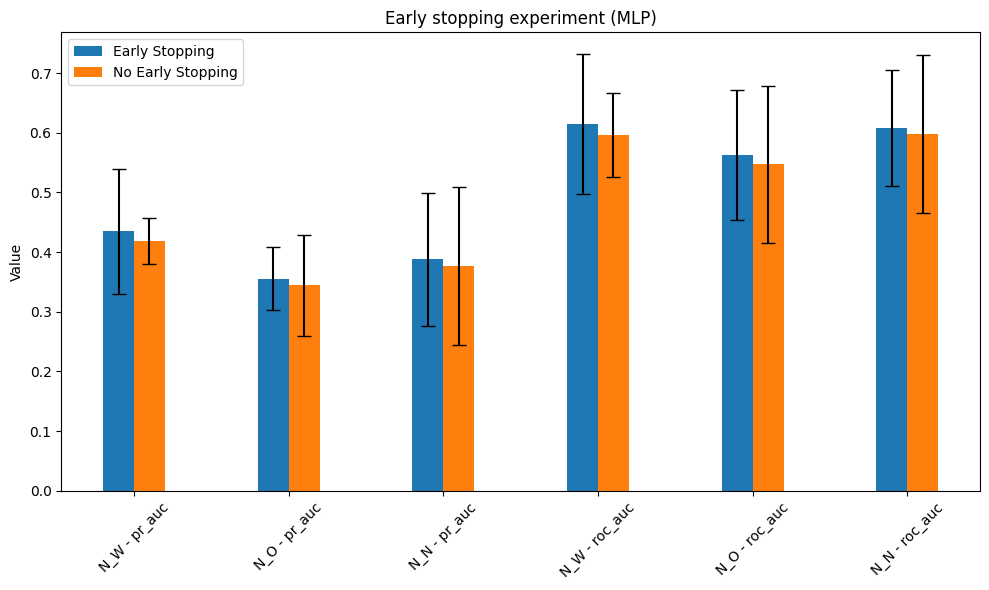

In [76]:
names = ["ValidProtocol_MLP"]

for n in names:
    save_dict = load_results(result_path, n)

    if "Valid" in n:
        model_name = n.split("_")[1]
    else:
        model_name = n

    plot_grouped_bars(save_dict, "Early Stopping", f"Early stopping experiment ({model_name})", f"{image_path}/EarlyStoppingExperiment({model_name}).png")

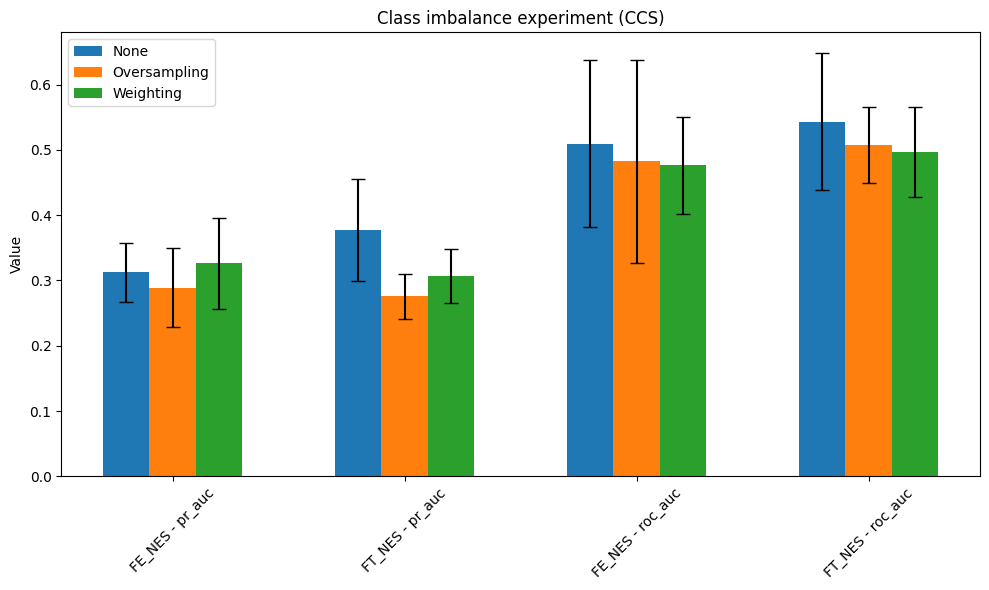

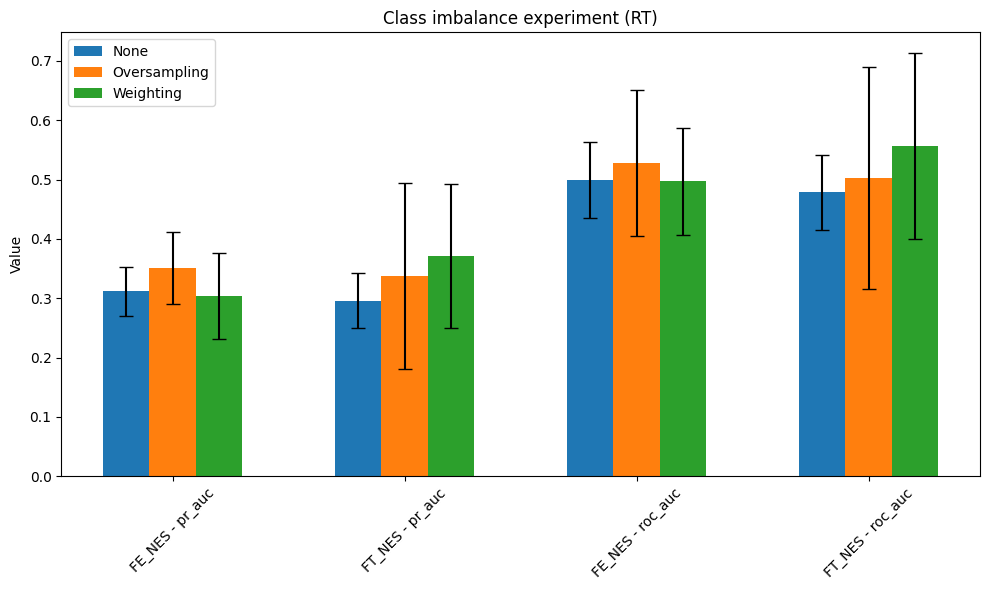

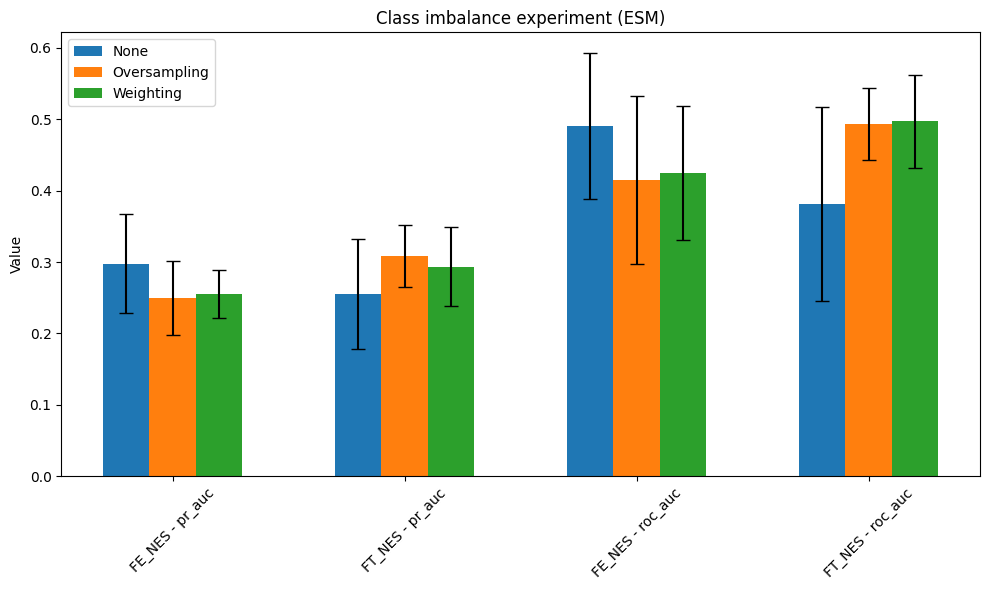

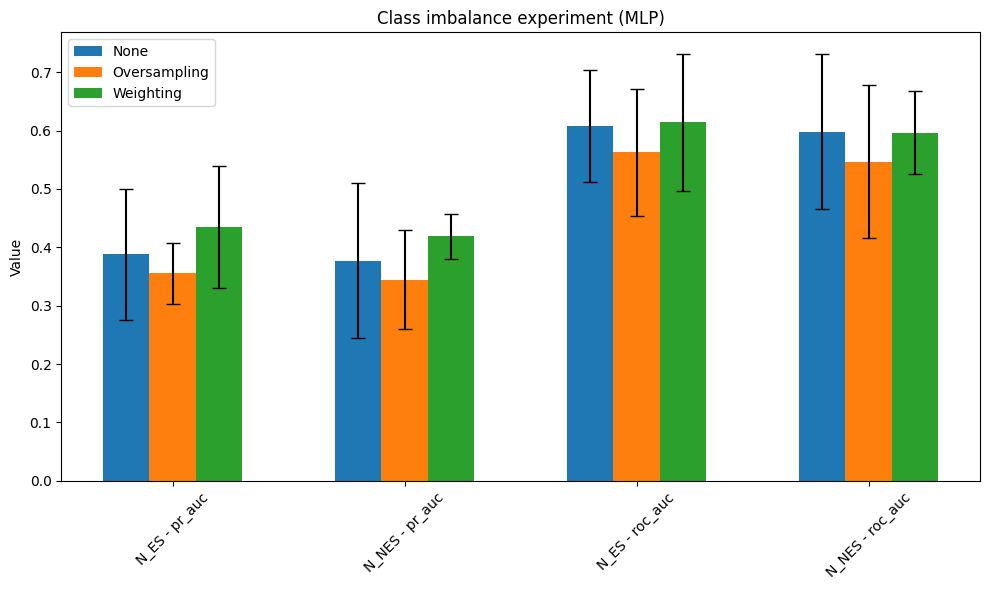

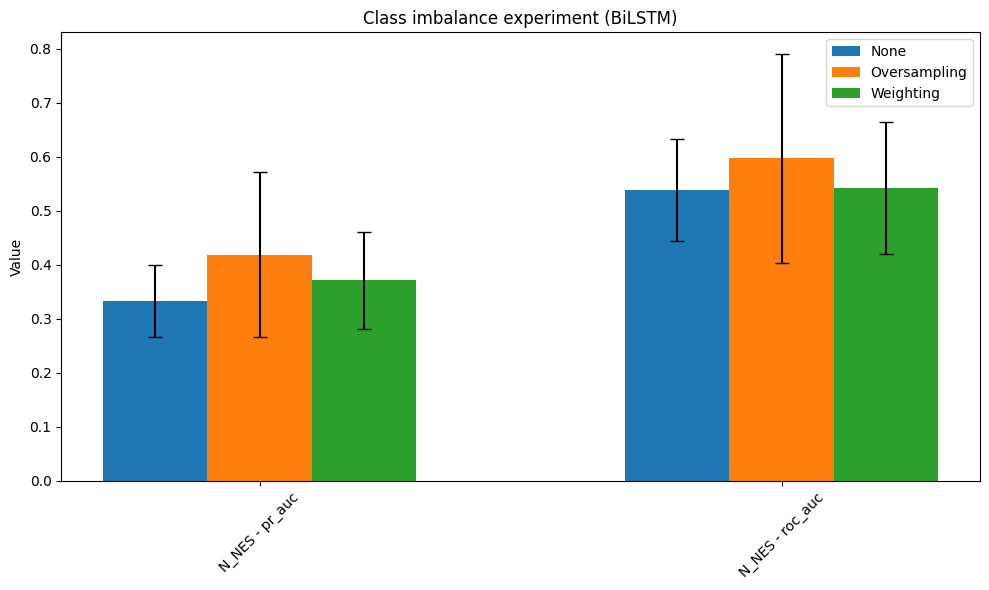

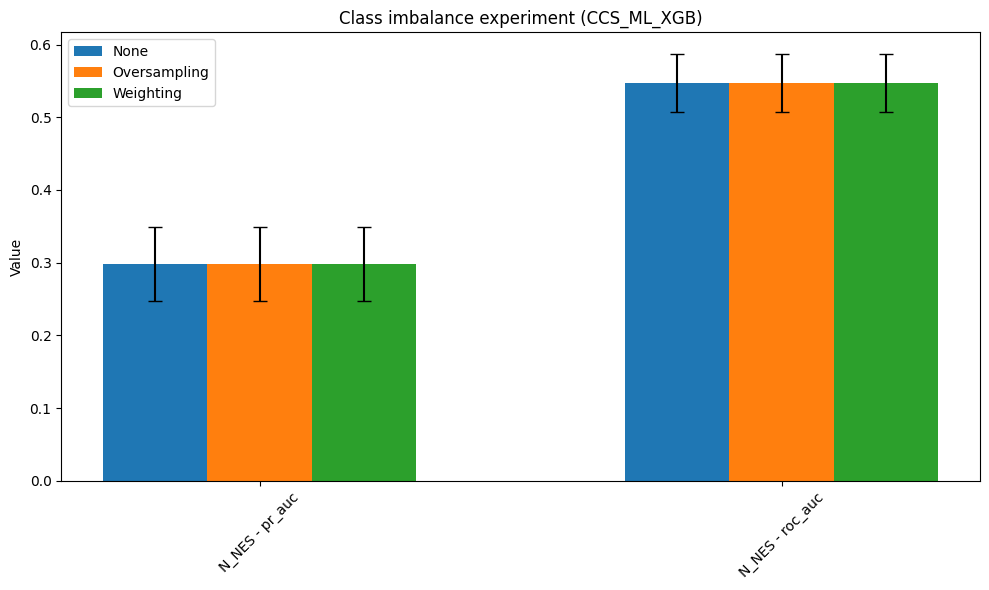

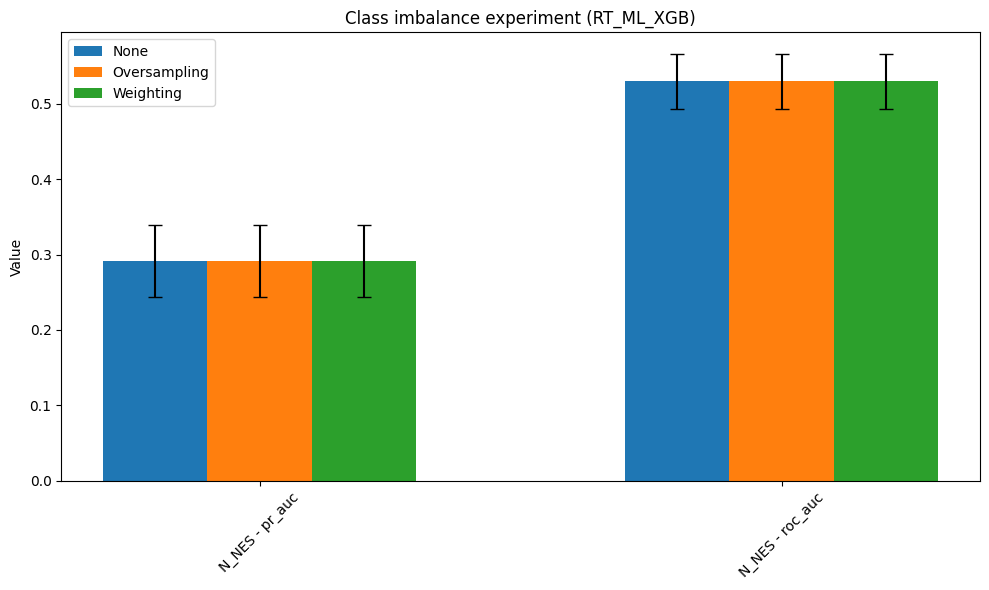

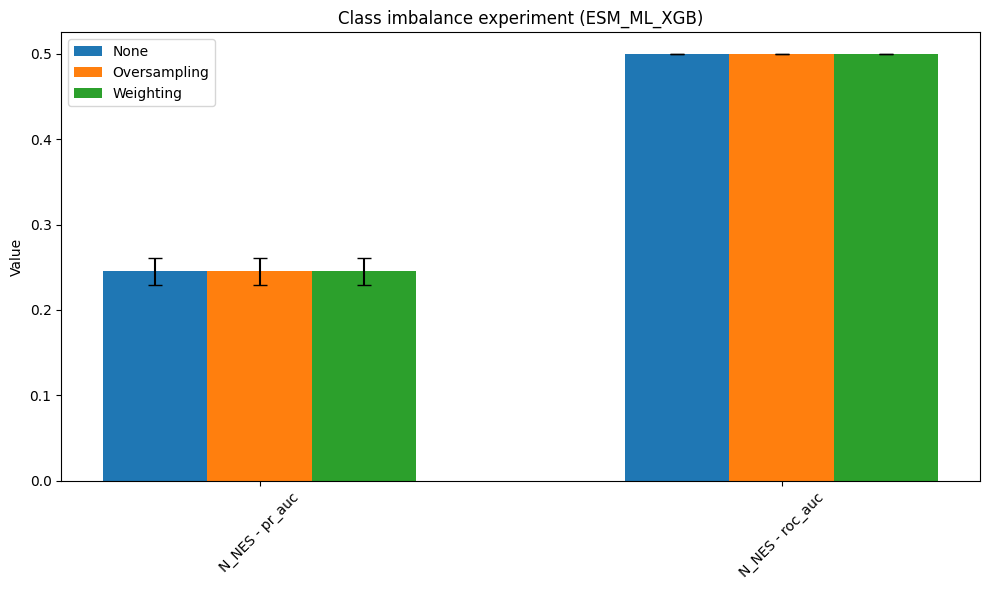

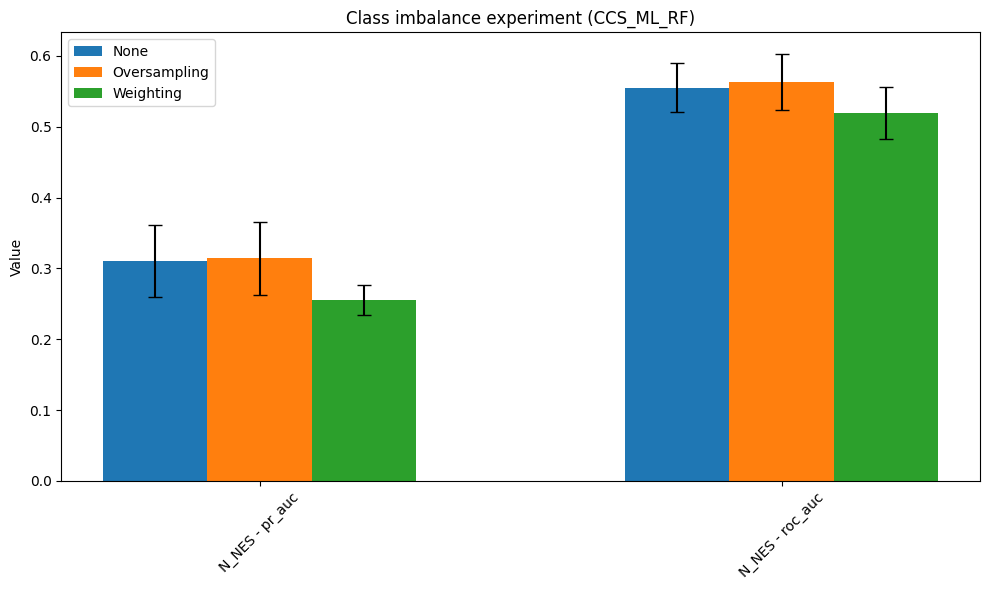

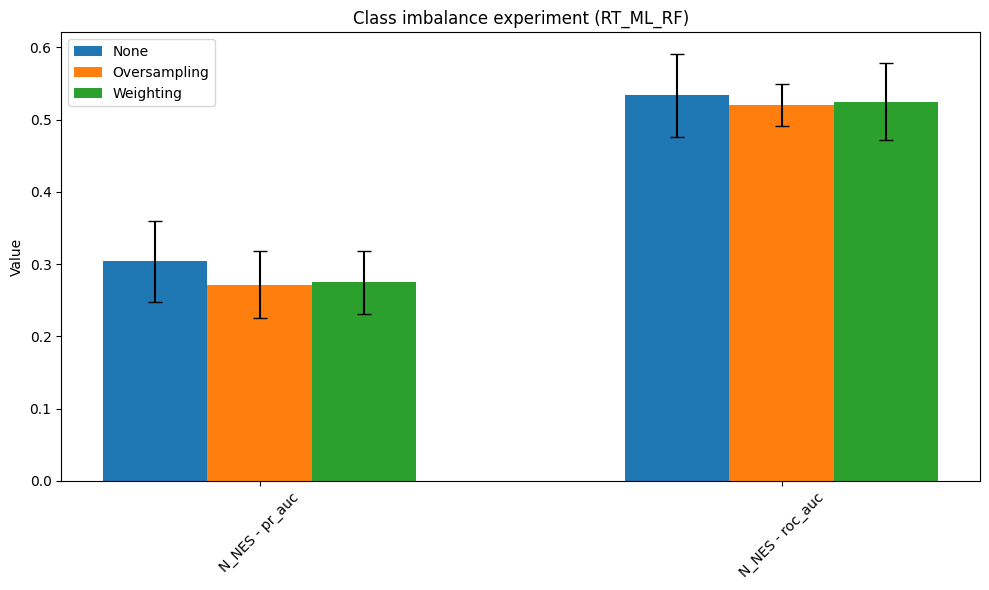

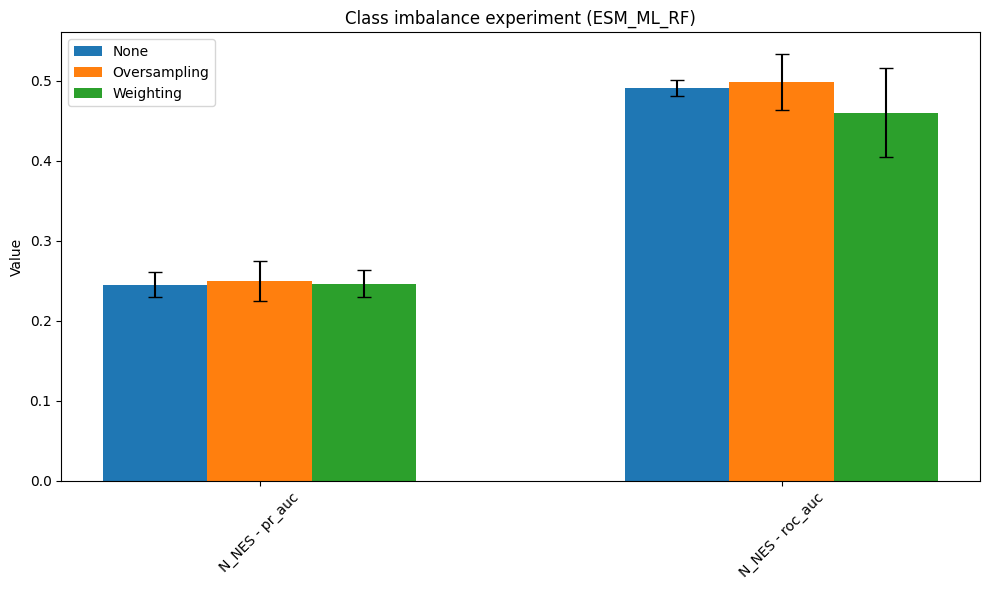

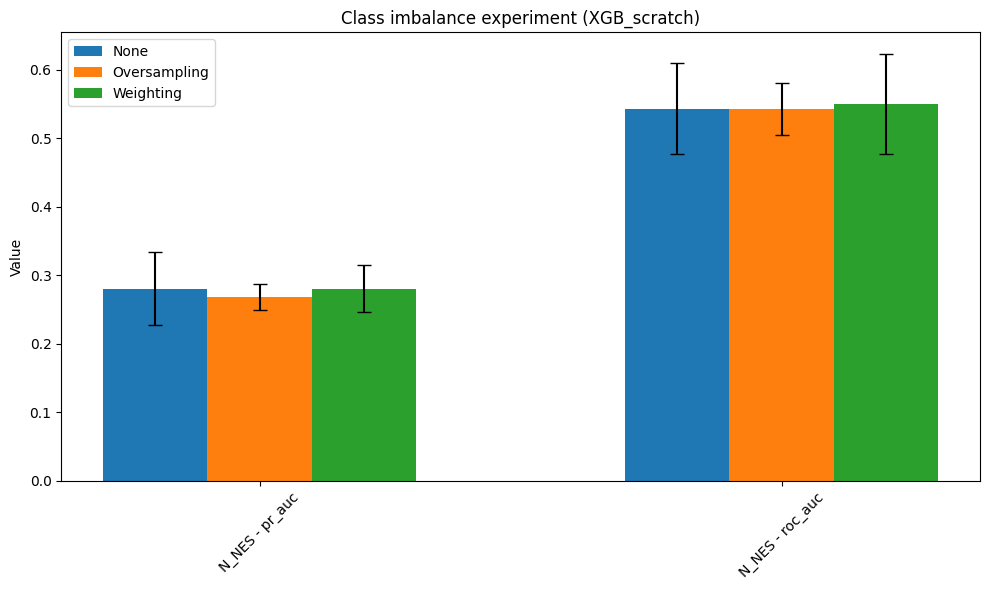

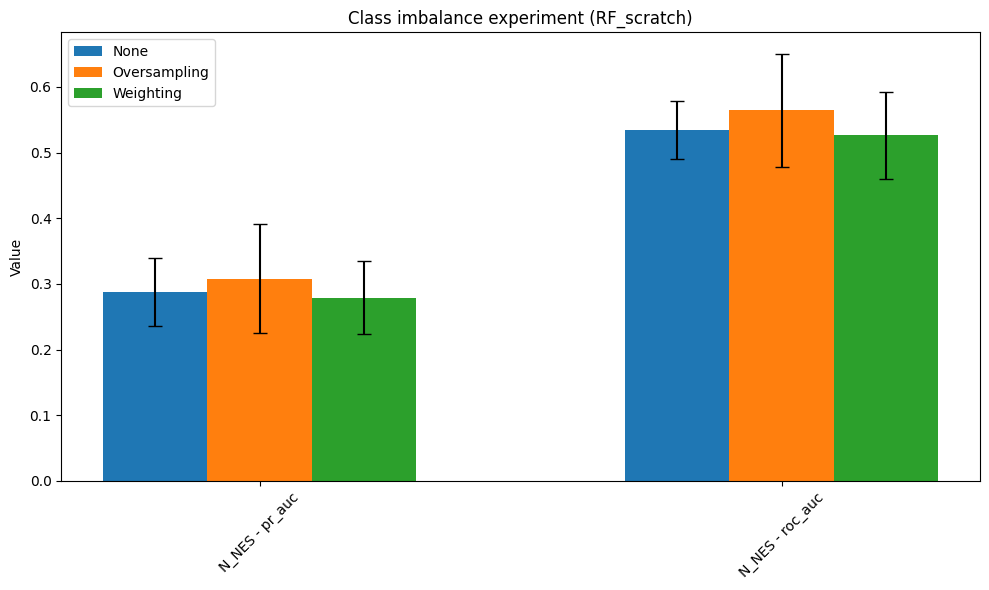

In [77]:
names = ["ValidProtocol_CCS", "ValidProtocol_RT", "ValidProtocol_ESM", "ValidProtocol_MLP", "ValidProtocol_BiLSTM",
         "CCS_ML_XGB", "RT_ML_XGB", "ESM_ML_XGB", "CCS_ML_RF", "RT_ML_RF", "ESM_ML_RF", "XGB_scratch", "RF_scratch"]

for n in names:
    save_dict = load_results(result_path, n)

    if "Valid" in n:
        model_name = n.split("_")[1]
    else:
        model_name = n

    plot_grouped_bars(save_dict, "Class Imbalance", f"Class imbalance experiment ({model_name})", f"{image_path}/ClassImbalanceExperiment({model_name}).png")

# Old version that plot for every metrics, the aggregation of the mean and std of an experiment

In [ ]:
def aggregate_metrics(path, file_name, metrics, target_list, target_value_list, ML = False):
  """
    Aggregates performance metrics from multiple experiment result files based on filtering conditions.

    Args:
        path (str): Directory containing the result JSON files.
        file_name (str): Substring to filter relevant filenames.
        metrics (list of str): List of metric names to aggregate (e.g., ["pr_auc", "roc_auc"]).
        target_list (list of str): List of keys to filter the JSON files (e.g., ["Fine tuning", "oversampling"]).
        target_value_list (list): List of corresponding values to match for each target key.
        ML (bool, optional): If True, extract metrics from "metrics_summary" (used in ML experiments);
                             if False, extract from "metrics". Defaults to False.

    Returns:
        dict: Dictionary containing the mean of each metric across matching files,
              with values rounded to 2 decimal places (e.g., {"pr_auc_mean": 0.85, "pr_auc_std": 0.02}).
    """
  dict_save = {f"{metric}_mean": 0 for metric in metrics}
  dict_save.update({f"{metric}_std": 0 for metric in metrics})

  count = 0
  for file in os.listdir(path):
      if file_name in file:
        with open(f"{path}/{file}", 'r') as f:
          data = json.load(f)

        skip_it = False
        for i, target in enumerate(target_list):
          target_value = target_value_list[i]
          if data[target] != target_value:
            skip_it = True
            break

        if skip_it:
          continue

        print(file)
        count += 1
        for m in metrics:
          if ML:
              dict_save[f"{m}_mean"] += data["metrics_summary"][f"{m}_mean"]
              dict_save[f"{m}_std"] += data["metrics_summary"][f"{m}_std"]
          else:
              dict_save[f"{m}_mean"] += data["metrics"][f"{m}_mean"]
              dict_save[f"{m}_std"] += data["metrics"][f"{m}_std"]

  print(count)
  dict_save = {k: np.round(v/count, 2) for k, v in dict_save.items()}

  return dict_save

In [ ]:
def plot_metrics(dicts_list, method_names, metrics, plot_type="bar", title="Comparison"):
    """
    Plots a comparison of model performance metrics across different methods.

    Supports bar plots or error bar plots to visualize mean values and standard deviations
    for a list of metrics.

    Args:
        dicts_list (list of dict): List of dictionaries containing metric results for each method.
        method_names (list of str): List of method names corresponding to each entry in dicts_list.
        metrics (list of str): List of metric names to plot (e.g., ["pr_auc", "roc_auc"]).
        plot_type (str, optional): Type of plot to generate. Options are "bar" or "errorbar".
                                   Defaults to "bar".
        title (str, optional): Title of the plot. Also used for the filename of the saved image.
                               Defaults to "Comparison".

    Returns:
        None: The plot is displayed and saved as a PNG file.
    """
    x = np.arange(len(metrics))
    width = 0.5 / len(dicts_list)
    shift = np.round(width/2, 2) * (len(dicts_list)-1)

    fig, ax = plt.subplots(figsize=(10, 6))

    if plot_type == "bar":
        for i, (dict_save, method) in enumerate(zip(dicts_list, method_names)):
            means = [dict_save[f"{metric}_mean"] for metric in metrics]
            stds = [dict_save[f"{metric}_std"] for metric in metrics]
            ax.bar(x + i * width, means, width, yerr=stds, capsize=5, alpha=0.7, label=method)

        ax.set_title(title)

    elif plot_type == "errorbar":
        for i, (dict_save, method) in enumerate(zip(dicts_list, method_names)):
            means = [dict_save[f"{metric}_mean"] for metric in metrics]
            stds = [dict_save[f"{metric}_std"] for metric in metrics]
            ax.errorbar(x + i * 0.1, means, yerr=stds, fmt='s', capsize=5, linestyle='None', markersize=8, label=method)

        ax.set_title(title)

    ax.set_xlabel("Metrics")
    ax.set_ylabel("Value")
    ax.set_ylim(0, 1)
    ax.set_xticks(x+shift)
    ax.set_xticklabels(metrics, rotation=20)
    ax.legend()

    plt.savefig(f"{image_path}/{title.replace(' ', '')}.png")
    plt.show()

ValidProtocol_CCS_Experiment_4.json
ValidProtocol_CCS_Experiment_5.json
ValidProtocol_CCS_Experiment_6.json
3
ValidProtocol_CCS_Experiment_1.json
ValidProtocol_CCS_Experiment_2.json
ValidProtocol_CCS_Experiment_3.json
3


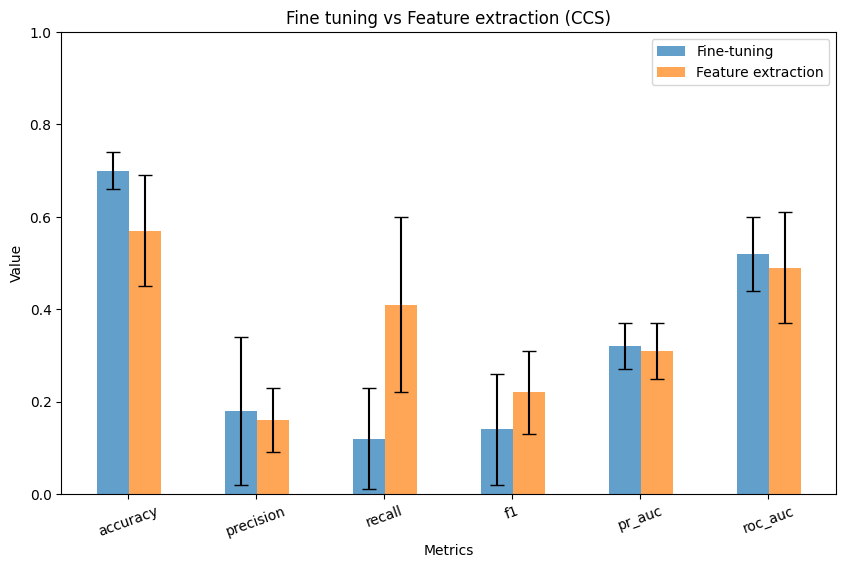

ValidProtocol_RT_Experiment_4.json
ValidProtocol_RT_Experiment_5.json
ValidProtocol_RT_Experiment_6.json
3
ValidProtocol_RT_Experiment_1.json
ValidProtocol_RT_Experiment_2.json
ValidProtocol_RT_Experiment_3.json
3


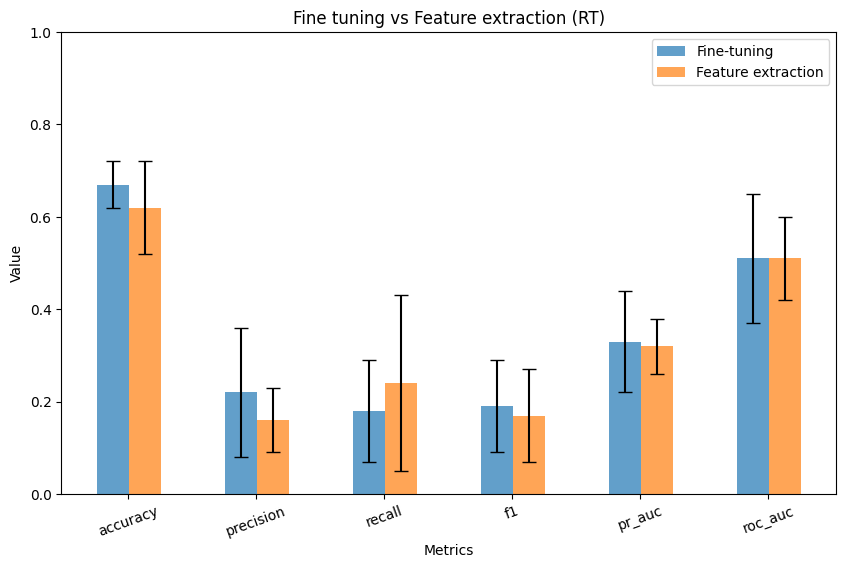

ValidProtocol_ESM_Experiment_6.json
ValidProtocol_ESM_Experiment_4.json
ValidProtocol_ESM_Experiment_5.json
3
ValidProtocol_ESM_Experiment_1.json
ValidProtocol_ESM_Experiment_3.json
ValidProtocol_ESM_Experiment_2.json
3


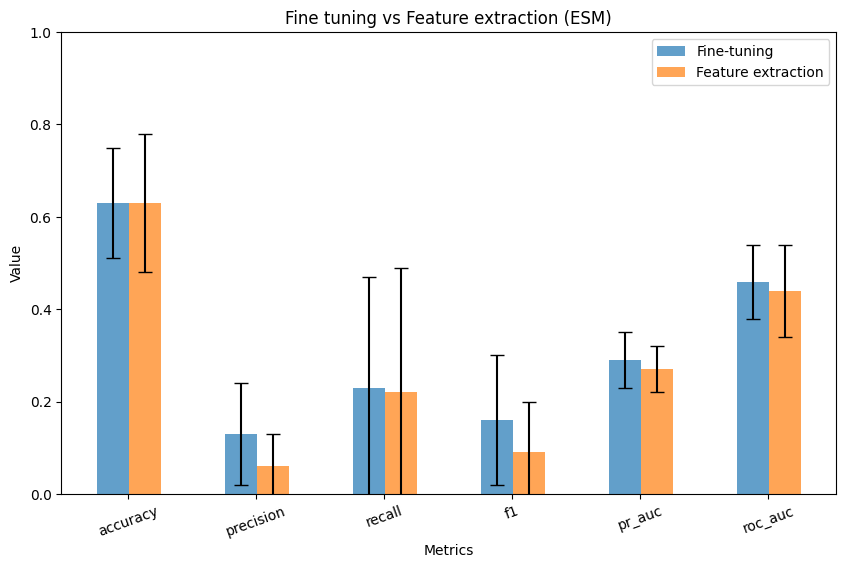

In [ ]:
names = ["ValidProtocol_CCS", "ValidProtocol_RT", "ValidProtocol_ESM"]

for n in names:
    fine_tuning_dict = aggregate_metrics(result_path, n, metrics, ["Fine tuning"], [True])
    feature_extraction_dict = aggregate_metrics(result_path, n, metrics, ["Fine tuning"], [False])

    model_name = n.split("_")[1]

    plot_metrics([fine_tuning_dict, feature_extraction_dict], ["Fine-tuning", "Feature extraction"], metrics, plot_type="bar", title=f"Fine tuning vs Feature extraction ({model_name})")

ValidProtocol_MLP_Experiment_4.json
ValidProtocol_MLP_Experiment_2.json
ValidProtocol_MLP_Experiment_6.json
3
ValidProtocol_MLP_Experiment_5.json
ValidProtocol_MLP_Experiment_3.json
ValidProtocol_MLP_Experiment_1.json
3


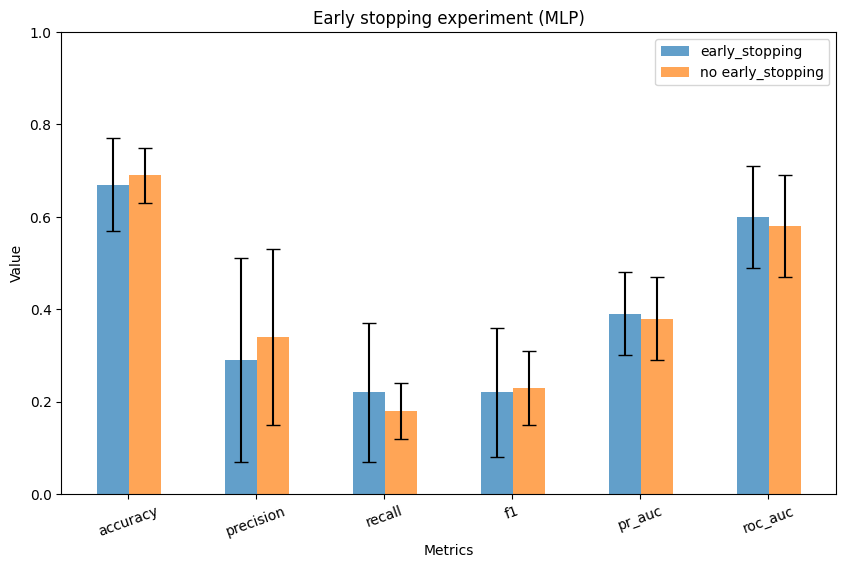

In [ ]:
early_stopping_dict = aggregate_metrics(result_path, "ValidProtocol_MLP", metrics, ["early_stopping"], [True])
NOearly_stopping_dict = aggregate_metrics(result_path, "ValidProtocol_MLP", metrics, ["early_stopping"], [False])

model_name = "MLP"

plot_metrics([early_stopping_dict, NOearly_stopping_dict], ["early_stopping", "no early_stopping"], metrics, plot_type="bar", title="Early stopping experiment (MLP)")

ValidProtocol_CCS_Experiment_2.json
ValidProtocol_CCS_Experiment_5.json
2
ValidProtocol_CCS_Experiment_3.json
ValidProtocol_CCS_Experiment_6.json
2
ValidProtocol_CCS_Experiment_1.json
ValidProtocol_CCS_Experiment_4.json
2


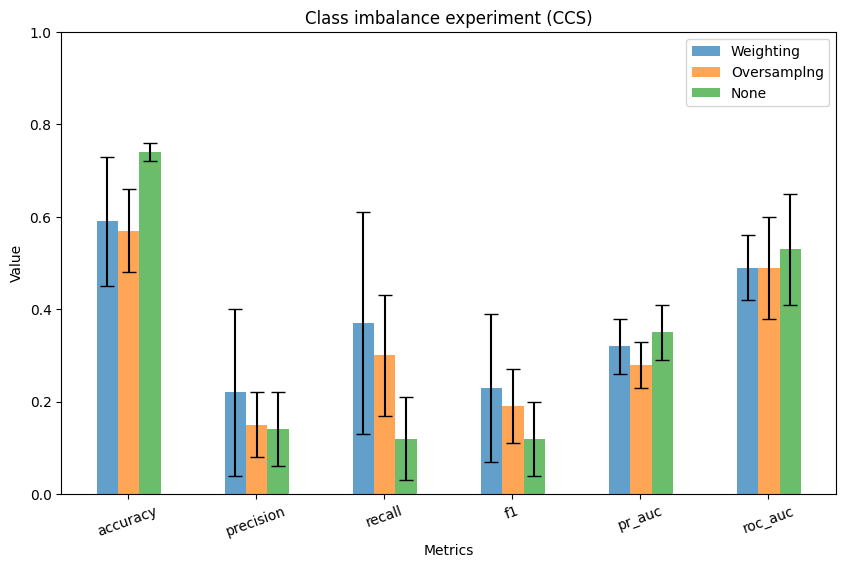

ValidProtocol_RT_Experiment_2.json
ValidProtocol_RT_Experiment_5.json
2
ValidProtocol_RT_Experiment_3.json
ValidProtocol_RT_Experiment_6.json
2
ValidProtocol_RT_Experiment_1.json
ValidProtocol_RT_Experiment_4.json
2


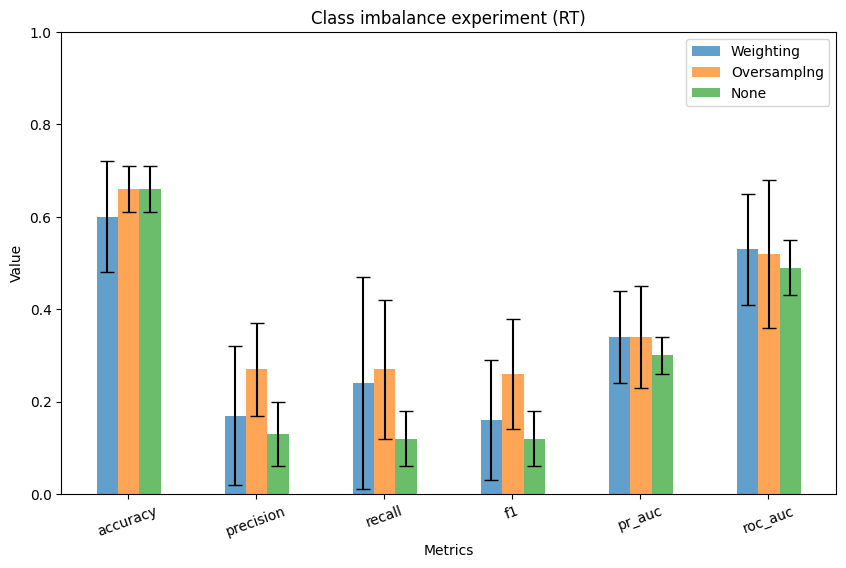

ValidProtocol_ESM_Experiment_5.json
ValidProtocol_ESM_Experiment_2.json
2
ValidProtocol_ESM_Experiment_6.json
ValidProtocol_ESM_Experiment_3.json
2
ValidProtocol_ESM_Experiment_1.json
ValidProtocol_ESM_Experiment_4.json
2


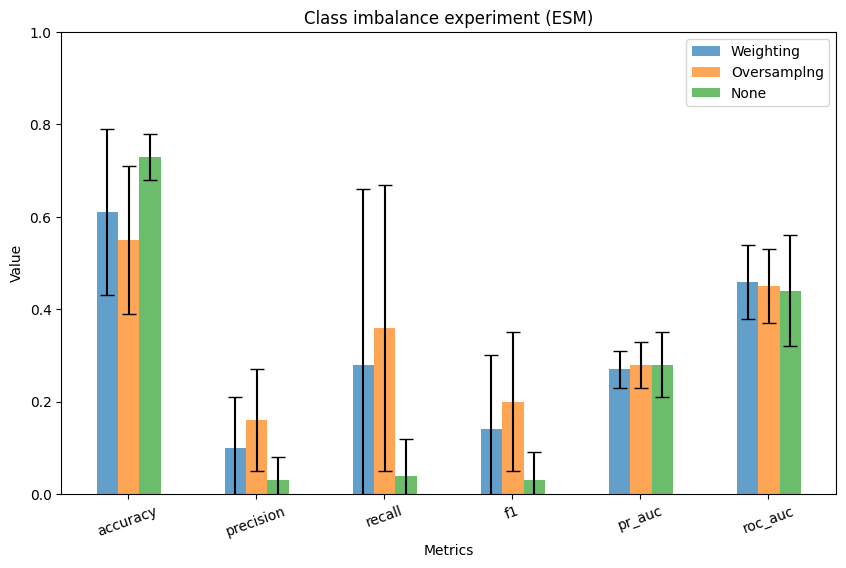

ValidProtocol_MLP_Experiment_4.json
ValidProtocol_MLP_Experiment_3.json
2
ValidProtocol_MLP_Experiment_5.json
ValidProtocol_MLP_Experiment_6.json
2
ValidProtocol_MLP_Experiment_2.json
ValidProtocol_MLP_Experiment_1.json
2


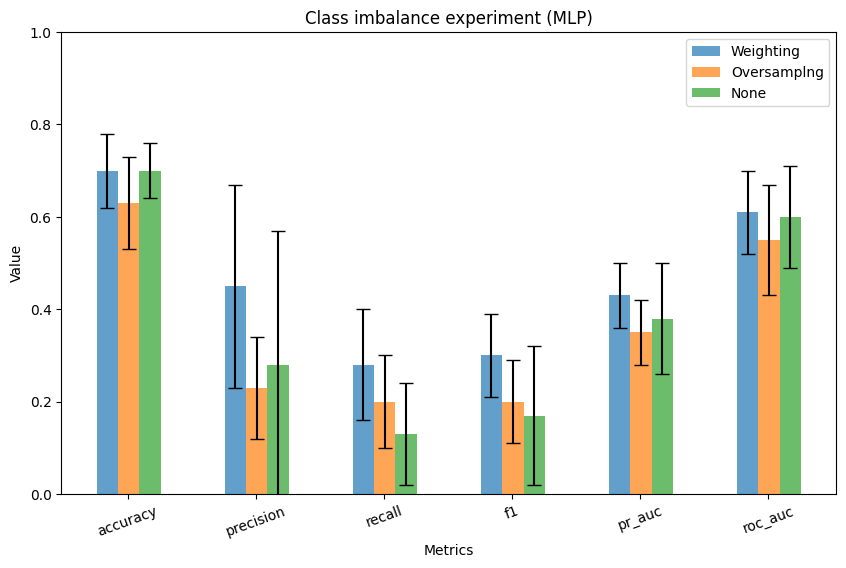

ValidProtocol_BiLSTM_Experiment_2.json
1
ValidProtocol_BiLSTM_Experiment_3.json
1
ValidProtocol_BiLSTM_Experiment_1.json
1


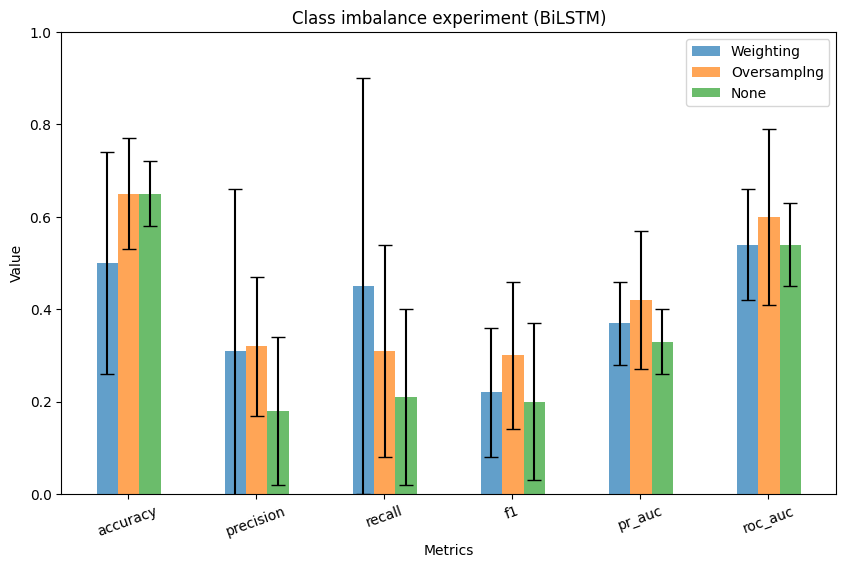

CCS_ML_XGB_experiment_2.json
1
CCS_ML_XGB_experiment_3.json
1
CCS_ML_XGB_experiment_1.json
1


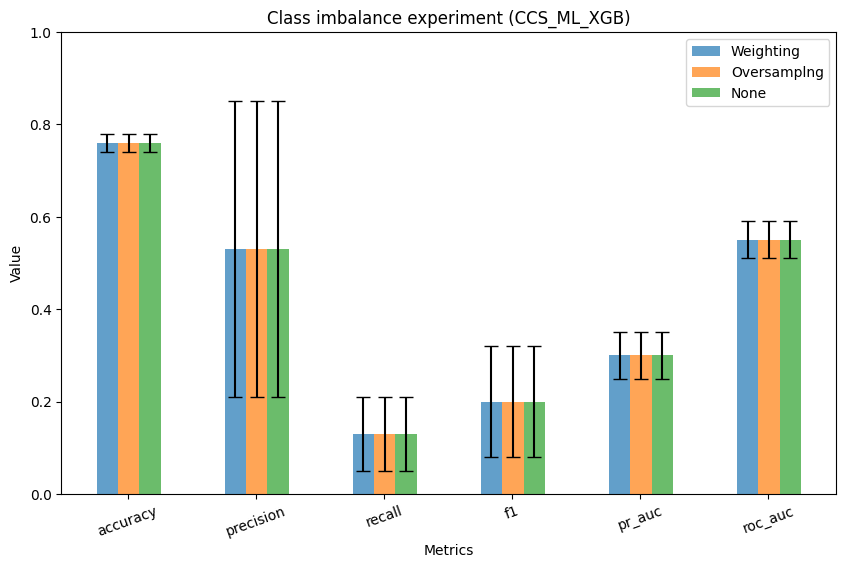

RT_ML_XGB_experiment_2.json
1
RT_ML_XGB_experiment_3.json
1
RT_ML_XGB_experiment_1.json
1


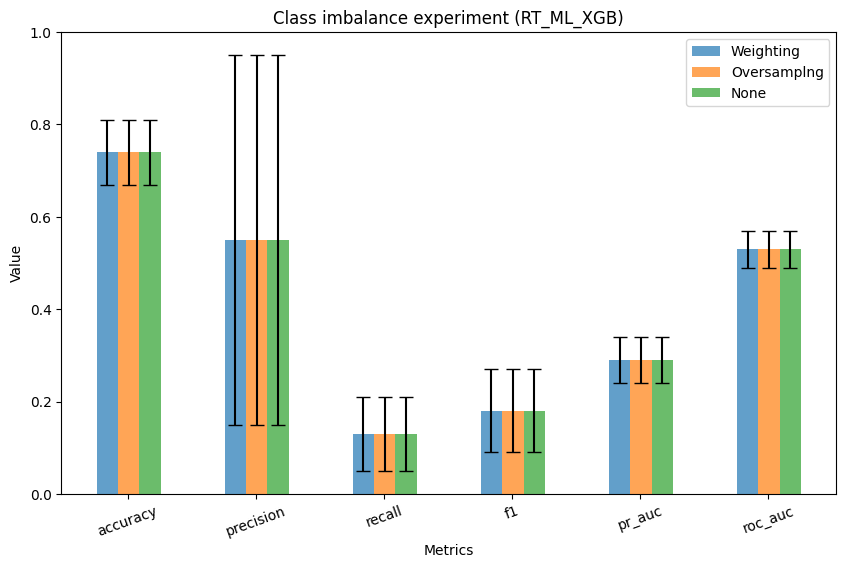

ESM_ML_XGB_experiment_2.json
1
ESM_ML_XGB_experiment_3.json
1
ESM_ML_XGB_experiment_1.json
1


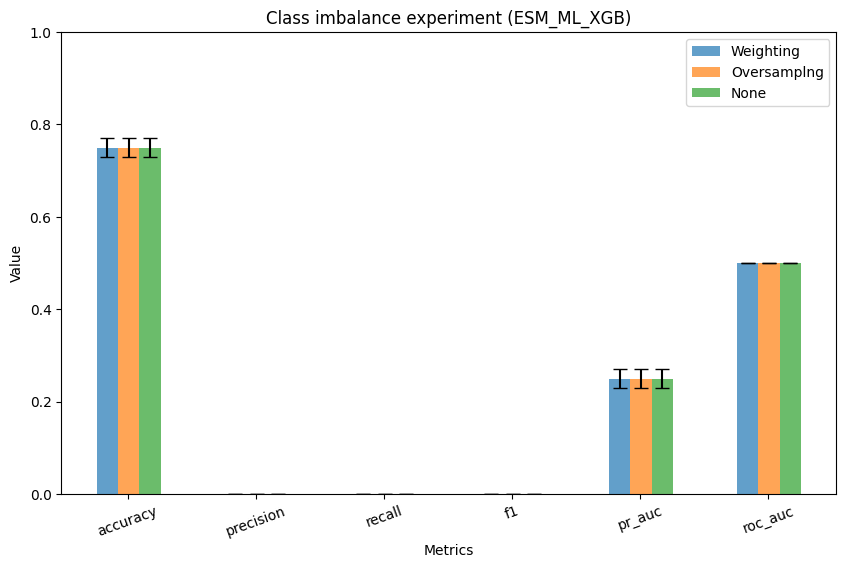

CCS_ML_RF_experiment_2.json
1
CCS_ML_RF_experiment_3.json
1
CCS_ML_RF_experiment_1.json
1


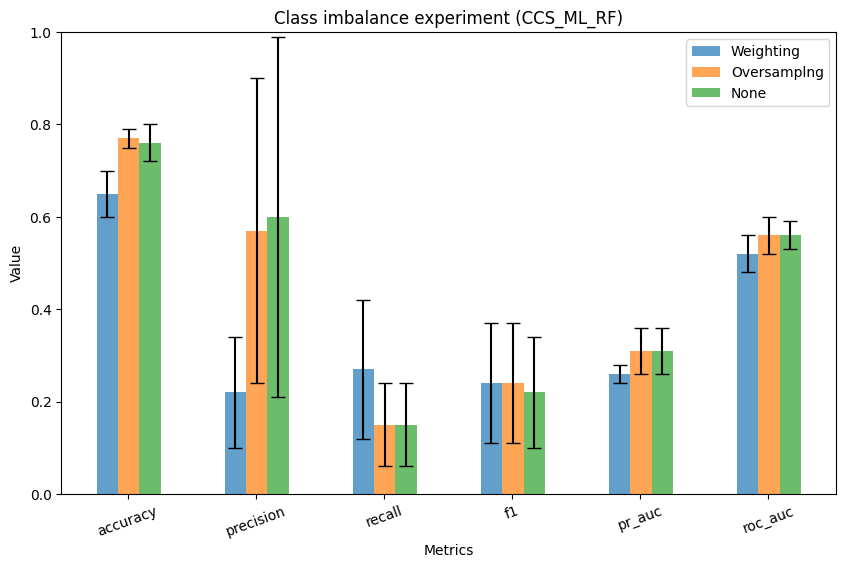

RT_ML_RF_experiment_2.json
1
RT_ML_RF_experiment_3.json
1
RT_ML_RF_experiment_1.json
1


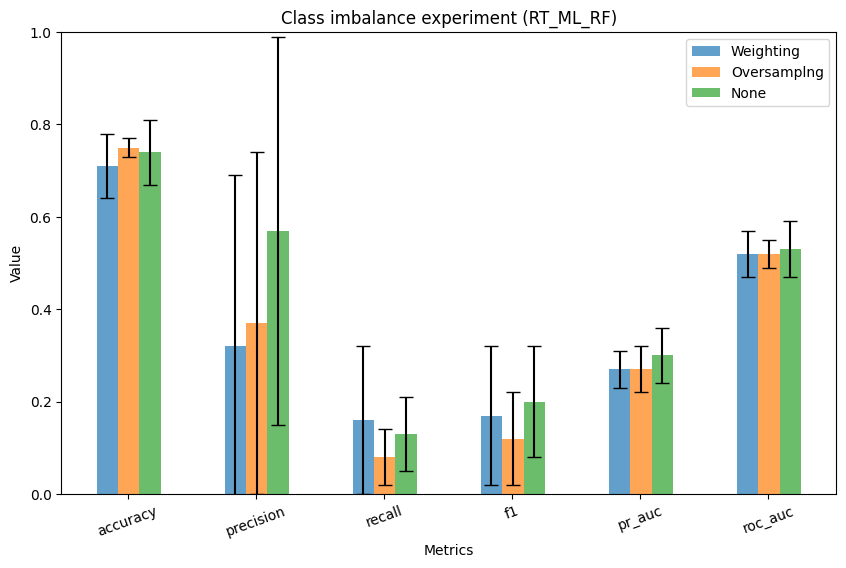

ESM_ML_RF_experiment_2.json
1
ESM_ML_RF_experiment_3.json
1
ESM_ML_RF_experiment_1.json
1


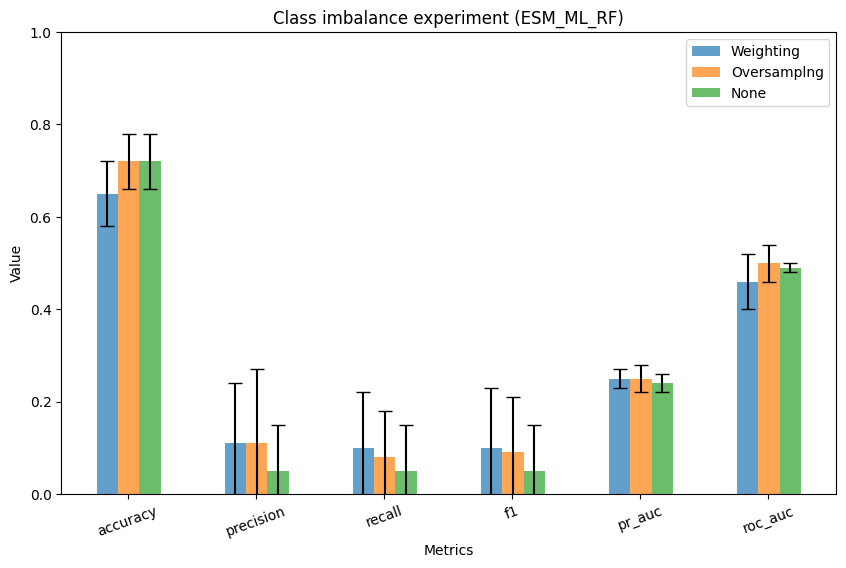

XGB_scratch_experiment_2.json
1
XGB_scratch_experiment_3.json
1
XGB_scratch_experiment_1.json
1


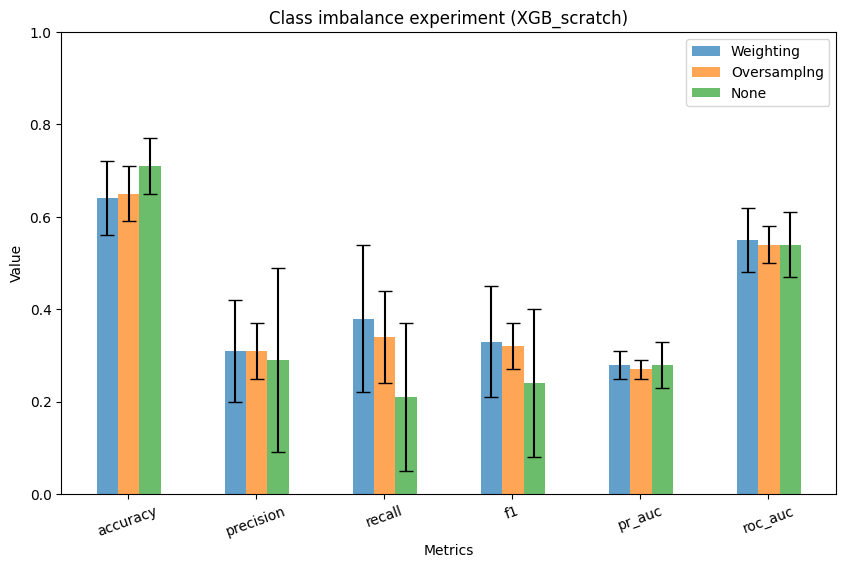

RF_scratch_experiment_2.json
1
RF_scratch_experiment_3.json
1
RF_scratch_experiment_1.json
1


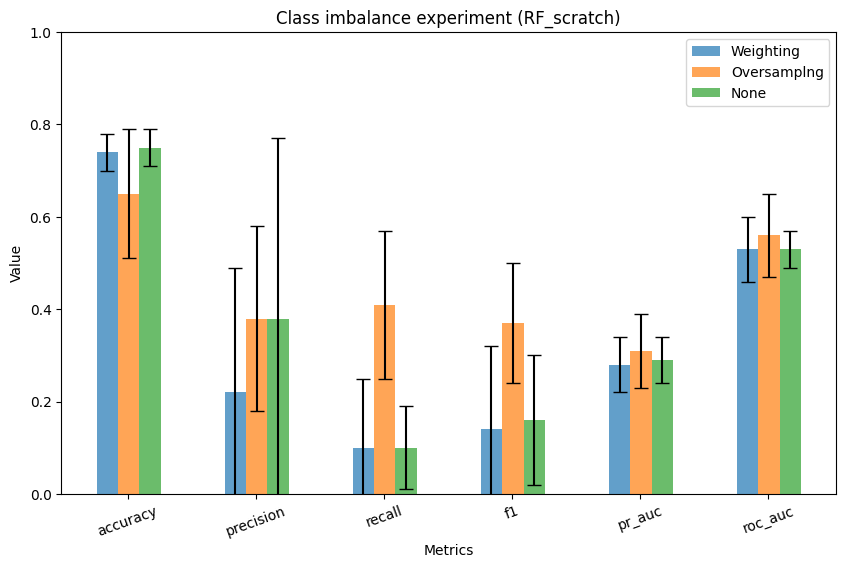

In [ ]:
names = ["ValidProtocol_CCS", "ValidProtocol_RT", "ValidProtocol_ESM", "ValidProtocol_MLP", "ValidProtocol_BiLSTM",
         "CCS_ML_XGB", "RT_ML_XGB", "ESM_ML_XGB", "CCS_ML_RF", "RT_ML_RF", "ESM_ML_RF", "XGB_scratch", "RF_scratch"]

for n in names:
    if ("ML" in n or "scratch" in n) and "MLP" not in n:
        ML = True
    else:
        ML = False

    weighting_dict = aggregate_metrics(result_path, n, metrics, ["weighting", "oversampling"], [True, False], ML = ML)
    oversampling_dict = aggregate_metrics(result_path, n, metrics, ["weighting", "oversampling"], [False, True], ML = ML)
    none_dict = aggregate_metrics(result_path, n, metrics, ["weighting", "oversampling"], [False, False], ML = ML)

    if "Valid" in n:
        model_name = n.split("_")[1]
    else:
        model_name = n

    plot_metrics([weighting_dict, oversampling_dict, none_dict], ["Weighting", "Oversamplng", "None"], metrics, plot_type="bar", title=f"Class imbalance experiment ({model_name})")

# Generate latex table

In [ ]:
def generate_latex_table(dicts_list, method_names, caption="Comparison of performance across variants"):
    """
    Generates a LaTeX table displaying performance metrics for multiple experimental variants.

    Args:
        dicts_list (list of dict): List of dictionaries containing mean and std values for each metric.
        method_names (list of str): List of method names corresponding to the dictionaries.
        caption (str, optional): Caption for the LaTeX table. Defaults to "Comparison of performance across variants".

    Returns:
        str: LaTeX code string representing the table.
    """
    metrics = ["accuracy", "precision", "recall", "f1", "pr_auc", "roc_auc"]
    metrics_name = ["Accuracy", "Precision", "Recall", "F1", "PR AUC", "ROC AUC"]

    latex_str = "\\begin{table}[H]\n\\centering\n"
    latex_str += "\\begin{tabular}{l|" + "c" * len(metrics) + "}\n"
    latex_str += "\\hline\n"

    latex_str += "Model & " + " & ".join(metrics_name) + " \\\\\n"
    latex_str += "\\hline\n"

    for method_name, dict_save in zip(method_names, dicts_list):
        values = [f"{dict_save[f'{metric}_mean']:.2f} $\pm$ {dict_save[f'{metric}_std']:.2f}" for metric in metrics]
        latex_str += f"{method_name} & " + " & ".join(values) + " \\\\\n"

    latex_str += "\\hline\n"
    latex_str += "\\end{tabular}\n"

    latex_str += f"\\caption{{{caption}}}\n"

    latex_str += "\\label{tab:comparison}\n"
    latex_str += "\\end{table}"

    return latex_str

In [ ]:
def process_json_files(path, file_name, ML = False):
    """
    Processes JSON result files and extracts method names and associated metrics.

    Args:
        path (str): Directory containing the result JSON files.
        file_name (str): Substring used to filter relevant filenames.
        ML (bool, optional): If True, identifies ML model types (XGB, RF) and extracts from "metrics_summary";
                             if False, extracts from "metrics". Defaults to False.

    Returns:
        tuple:
            - methods_names (list of str): List of experiment labels including conditions and model type (if ML=True).
            - metric_list (list of dict): List of metric dictionaries from each file.
    """
    methods_names = []
    metric_list = []

    for file in os.listdir(path):
        if file_name in file:
            print(file)

            with open(os.path.join(path, file), 'r') as f:
                data = json.load(f)

            Fine_tuning = "N" if "Fine tuning" not in data else "FT" if data["Fine tuning"] else "FE"
            Early_stopping = "ES" if data.get("early_stopping", False) else "NES"
            class_imbalanced = "O" if data.get("oversampling", False) else "W" if data.get("weighting", False) else "N"

            if ML:
              metric_list.append(data.get("metrics_summary", {}))
            else:
              metric_list.append(data.get("metrics", {}))

            if ML:
              if "XGB" in file:
                methods_names.append(f"{file_name}\_XGB\_{Early_stopping}\_{Fine_tuning}\_{class_imbalanced}")
              elif "RF" in file:
                methods_names.append(f"{file_name}\_RF\_{Early_stopping}\_{Fine_tuning}\_{class_imbalanced}")
            else:
              methods_names.append(f"{file_name}\_{Early_stopping}\_{Fine_tuning}\_{class_imbalanced}")

    return methods_names, metric_list

In [ ]:
file_names = ["ValidProtocol_CCS", "ValidProtocol_RT", "ValidProtocol_ESM", "ValidProtocol_MLP", "ValidProtocol_BiLSTM"]

for f in file_names:
  methods_names, metric_list = process_json_files(f"{result_path}/ExperimentFirstPart", f)
  if not metric_list:
    continue

  ltxtbl = generate_latex_table(metric_list, methods_names, f"{f} intra model comparison")

  output_file = f"{tex_path}/{f}_intra_model_comparison.txt"

  with open(output_file, 'w', encoding='utf-8') as fw:
      fw.write(ltxtbl)

ValidProtocol_CCS_Experiment_1.json
ValidProtocol_CCS_Experiment_2.json
ValidProtocol_CCS_Experiment_3.json
ValidProtocol_CCS_Experiment_4.json
ValidProtocol_CCS_Experiment_5.json
ValidProtocol_CCS_Experiment_6.json
ValidProtocol_RT_Experiment_1.json
ValidProtocol_RT_Experiment_2.json
ValidProtocol_RT_Experiment_3.json
ValidProtocol_RT_Experiment_4.json
ValidProtocol_RT_Experiment_5.json
ValidProtocol_RT_Experiment_6.json
ValidProtocol_ESM_Experiment_3.json
ValidProtocol_ESM_Experiment_4.json
ValidProtocol_ESM_Experiment_1.json
ValidProtocol_ESM_Experiment_6.json
ValidProtocol_ESM_Experiment_2.json
ValidProtocol_ESM_Experiment_5.json
ValidProtocol_MLP_Experiment_3.json
ValidProtocol_MLP_Experiment_2.json
ValidProtocol_MLP_Experiment_5.json
ValidProtocol_MLP_Experiment_4.json
ValidProtocol_MLP_Experiment_6.json
ValidProtocol_MLP_Experiment_1.json
ValidProtocol_BiLSTM_Experiment_2.json
ValidProtocol_BiLSTM_Experiment_1.json
ValidProtocol_BiLSTM_Experiment_3.json


In [ ]:
file_names = ["RT_ML", "CCS_ML", "ESM_ML", "scratch"]

for f in file_names:
  methods_names, metric_list = process_json_files(f"{result_path}/ExperimentFirstPart", f, True)
  if not metric_list:
    continue

  ltxtbl = generate_latex_table(metric_list, methods_names, f"{f} intra model comparison")

  output_file = f"{tex_path}/{f}_intra_model_comparison.txt"

  with open(output_file, 'w', encoding='utf-8') as fw:
      fw.write(ltxtbl)

RT_ML_XGB_experiment_1.json
RT_ML_RF_experiment_1.json
RT_ML_RF_experiment_3.json
RT_ML_XGB_experiment_3.json
RT_ML_RF_experiment_2.json
RT_ML_XGB_experiment_2.json
CCS_ML_XGB_experiment_2.json
CCS_ML_RF_experiment_3.json
CCS_ML_RF_experiment_1.json
CCS_ML_XGB_experiment_1.json
CCS_ML_RF_experiment_2.json
CCS_ML_XGB_experiment_3.json
ESM_ML_XGB_experiment_2.json
ESM_ML_XGB_experiment_3.json
ESM_ML_XGB_experiment_1.json
ESM_ML_RF_experiment_2.json
ESM_ML_RF_experiment_3.json
ESM_ML_RF_experiment_1.json
RF_scratch_experiment_1.json
RF_scratch_experiment_2.json
RF_scratch_experiment_3.json
XGB_scratch_experiment_1.json
XGB_scratch_experiment_2.json
XGB_scratch_experiment_3.json
